<a href="https://www.kaggle.com/code/kopkritsaikhiao/ds-salaries-for-non-resident-and-predict?scriptVersionId=135365391" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install chart_studio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 2.6 MB/s eta 0:00:00


# 1. Loading data and importing libraries

In [2]:
!pip install pycountry

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 57.2 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for pycountry: filename=pycountry-22.3.5-py2.py3-none-any.whl size=10681832 sha256=1e83c7417f311e65c90dbe18828d09d71e616be97e64580f32329b6b27b238a8
  Stored in directory: /root/.cache/pip/wheels/03/57/cc/290c5252ec97a6d78d36479a3c5e5ecc76318afcb241ad9dbe
Successfully built pycountry


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pycountry
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset

import torch.nn as nn

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-science-salaries-2023/ds_salaries.csv


I know most of all peole here want to get a job in data. so, come to explore it together !!!

In [4]:
# load data and look at the head of df
df = pd.read_csv("/kaggle/input/data-science-salaries-2023/ds_salaries.csv")
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


In [5]:
# look at the tail of the df
df.tail()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
3750,2020,SE,FT,Data Scientist,412000,USD,412000,US,100,US,L
3751,2021,MI,FT,Principal Data Scientist,151000,USD,151000,US,100,US,L
3752,2020,EN,FT,Data Scientist,105000,USD,105000,US,100,US,S
3753,2020,EN,CT,Business Data Analyst,100000,USD,100000,US,100,US,L
3754,2021,SE,FT,Data Science Manager,7000000,INR,94665,IN,50,IN,L


# 2. Chage some of data value to make it easy to understand 

In [6]:
# work_year
df['work_year'] = (df['work_year'] - 2023)*-1
df.tail()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
3750,3,SE,FT,Data Scientist,412000,USD,412000,US,100,US,L
3751,2,MI,FT,Principal Data Scientist,151000,USD,151000,US,100,US,L
3752,3,EN,FT,Data Scientist,105000,USD,105000,US,100,US,S
3753,3,EN,CT,Business Data Analyst,100000,USD,100000,US,100,US,L
3754,2,SE,FT,Data Science Manager,7000000,INR,94665,IN,50,IN,L


In [7]:
df['remote_ratio'] = df['remote_ratio'].apply(lambda x: int(x / 50))
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,2,ES,L
1,0,MI,CT,ML Engineer,30000,USD,30000,US,2,US,S
2,0,MI,CT,ML Engineer,25500,USD,25500,US,2,US,S
3,0,SE,FT,Data Scientist,175000,USD,175000,CA,2,CA,M
4,0,SE,FT,Data Scientist,120000,USD,120000,CA,2,CA,M


In [8]:
# look at experience_level values
unique_levels = df['experience_level'].unique()

print(unique_levels)

['SE' 'MI' 'EN' 'EX']


In [9]:
# Change it
df['experience_level'] = df['experience_level'].replace({'SE': 'Senior', 'MI': 'Mid-level', 'EN': 'Entry', 'EX': 'Executive/Lead'})
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,Senior,FT,Principal Data Scientist,80000,EUR,85847,ES,2,ES,L
1,0,Mid-level,CT,ML Engineer,30000,USD,30000,US,2,US,S
2,0,Mid-level,CT,ML Engineer,25500,USD,25500,US,2,US,S
3,0,Senior,FT,Data Scientist,175000,USD,175000,CA,2,CA,M
4,0,Senior,FT,Data Scientist,120000,USD,120000,CA,2,CA,M


In [10]:
# look at employment_type values
unique_employment_type = df['employment_type'].unique()

print(unique_employment_type)

['FT' 'CT' 'FL' 'PT']


In [11]:
# change it
df['employment_type'] = df['employment_type'].replace({'FT': 'Full-Time', 'CT': 'Contract', 'FL': 'Freelance', 'PT': 'Part-Time'})
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,Senior,Full-Time,Principal Data Scientist,80000,EUR,85847,ES,2,ES,L
1,0,Mid-level,Contract,ML Engineer,30000,USD,30000,US,2,US,S
2,0,Mid-level,Contract,ML Engineer,25500,USD,25500,US,2,US,S
3,0,Senior,Full-Time,Data Scientist,175000,USD,175000,CA,2,CA,M
4,0,Senior,Full-Time,Data Scientist,120000,USD,120000,CA,2,CA,M


In [12]:
# Define function to find country name
def get_country_name(country_code):
    try:
        result = pycountry.countries.get(alpha_2=country_code)
    except Exception:
        return np.nan
    else:
        if result is None:
            return np.nan
        else:
            return result.name

# Given ISO Alpha-2 code, return full country name
df["employee_residence"] = df["employee_residence"].apply(lambda country_code: get_country_name(country_code))
df["company_location"] = df["company_location"].apply(lambda country_code: get_country_name(country_code))
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,Senior,Full-Time,Principal Data Scientist,80000,EUR,85847,Spain,2,Spain,L
1,0,Mid-level,Contract,ML Engineer,30000,USD,30000,United States,2,United States,S
2,0,Mid-level,Contract,ML Engineer,25500,USD,25500,United States,2,United States,S
3,0,Senior,Full-Time,Data Scientist,175000,USD,175000,Canada,2,Canada,M
4,0,Senior,Full-Time,Data Scientist,120000,USD,120000,Canada,2,Canada,M


# 3. Time to explore data

In [13]:
# Use the describe() function to get summary statistics of the DataFrame
df.describe()

,work_year,salary,salary_in_usd,remote_ratio
count,3755.000000,3.755000e+03,3755.000000,3755.000000
mean,0.626365,1.906956e+05,137570.389880,0.925433
std,0.691448,6.716765e+05,63055.625278,0.971781
min,0.000000,6.000000e+03,5132.000000,0.000000
25%,0.000000,1.000000e+05,95000.000000,0.000000
50%,1.000000,1.380000e+05,135000.000000,0.000000
75%,1.000000,1.800000e+05,175000.000000,2.000000
max,3.000000,3.040000e+07,450000.000000,2.000000


I find it fascinating because the average salary is around 137,570 USD.

Which is considerably high compared to the average salary in Thailand.

That the reason why I want to chage career path to be a data scientist.

In [14]:
# print all unique value
def summary(df):
    print(f"Dataset has {df.shape[1]} features and {df.shape[0]} examples.")
    summary = pd.DataFrame(index=df.columns)
    summary["Unique"] = df.nunique().values
    summary["Missing"] = df.isnull().sum().values
    summary["Duplicated"] = df.duplicated().sum()
    summary["Types"] = df.dtypes
    return summary

summary(df)

Dataset has 11 features and 3755 examples.


,Unique,Missing,Duplicated,Types
work_year,4,0,1171,int64
experience_level,4,0,1171,object
employment_type,4,0,1171,object
job_title,93,0,1171,object
salary,815,0,1171,int64
salary_currency,20,0,1171,object
salary_in_usd,1035,0,1171,int64
employee_residence,78,0,1171,object
remote_ratio,3,0,1171,int64
company_location,72,0,1171,object


we can see there are a lot of values in job_title

In [15]:
unique_job_title = df['job_title'].unique()

# Create a DataFrame with the unique job titles
df_job_titles = pd.DataFrame({'job_title': unique_job_title})

# Group the job titles by common themes
grouped_job_titles = df_job_titles.groupby(df_job_titles['job_title'].str.split().str[0]).agg({'job_title': ', '.join})

# Print the grouped job titles
print("Grouped Job Titles:")
for group, titles in grouped_job_titles.iterrows():
    print("- " + group + ":")
    print("  " + titles['job_title'])
    print()


Grouped Job Titles:
- 3D:
  3D Computer Vision Researcher

- AI:
  AI Developer, AI Scientist, AI Programmer

- Analytics:
  Analytics Engineer

- Applied:
  Applied Scientist, Applied Machine Learning Engineer, Applied Data Scientist, Applied Machine Learning Scientist

- Autonomous:
  Autonomous Vehicle Technician

- Azure:
  Azure Data Engineer

- BI:
  BI Data Engineer, BI Developer, BI Analyst, BI Data Analyst

- Big:
  Big Data Engineer, Big Data Architect

- Business:
  Business Intelligence Engineer, Business Data Analyst

- Cloud:
  Cloud Database Engineer, Cloud Data Engineer, Cloud Data Architect

- Compliance:
  Compliance Data Analyst

- Computer:
  Computer Vision Engineer, Computer Vision Software Engineer

- Data:
  Data Scientist, Data Analyst, Data Modeler, Data Strategist, Data Engineer, Data Quality Analyst, Data Architect, Data Analytics Manager, Data DevOps Engineer, Data Science Manager, Data Manager, Data Specialist, Data Infrastructure Engineer, Data Operations

In [16]:
# Count the number of job titles in each group
count_per_group = df['job_title'].value_counts()

# Print the grouped job titles with count
print("Grouped Job Titles:")
for group, count in count_per_group.iteritems():
    print(f"- {group}: {count}")

Grouped Job Titles:
- Data Engineer: 1040
- Data Scientist: 840
- Data Analyst: 612
- Machine Learning Engineer: 289
- Analytics Engineer: 103
- Data Architect: 101
- Research Scientist: 82
- Data Science Manager: 58
- Applied Scientist: 58
- Research Engineer: 37
- ML Engineer: 34
- Data Manager: 29
- Machine Learning Scientist: 26
- Data Science Consultant: 24
- Data Analytics Manager: 22
- Computer Vision Engineer: 18
- AI Scientist: 16
- BI Data Analyst: 15
- Business Data Analyst: 15
- Data Specialist: 14
- BI Developer: 13
- Applied Machine Learning Scientist: 12
- Machine Learning Infrastructure Engineer: 11
- Big Data Engineer: 11
- Director of Data Science: 11
- AI Developer: 11
- Applied Data Scientist: 10
- Head of Data: 10
- Machine Learning Software Engineer: 10
- Data Operations Engineer: 10
- ETL Developer: 10
- BI Analyst: 9
- Head of Data Science: 9
- Lead Data Scientist: 9
- Data Science Lead: 8
- Principal Data Scientist: 8
- Data Quality Analyst: 7
- NLP Engineer: 7

/tmp/ipykernel_20/3707405844.py:6: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for group, count in count_per_group.iteritems():


so, you can see that the most top 3 hired job are:

- Data Engineer: 1040
- Data Scientist: 840
- Data Analyst: 612

In [17]:
df.columns

Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'salary', 'salary_currency', 'salary_in_usd', 'employee_residence',
       'remote_ratio', 'company_location', 'company_size'],
      dtype='object')

In [18]:
selected_columns = ['work_year', 'experience_level', 'employment_type', 
                    'salary_currency', 'salary_in_usd', 'employee_residence',
                    'remote_ratio', 'company_location', 'company_size']

import plotly.express as px

def plot_distributions(df):
    for column in selected_columns:
        fig = px.histogram(df, x=column, nbins=30, title=f"Distribution of {column}")
        fig.update_layout(
            xaxis_title=column,
            yaxis_title="Frequency",
            xaxis={'tickangle': -45},
            showlegend=False
        )
        fig.show()

plot_distributions(df)

from the plow above we can see the distribution for each features data.

In [19]:
df.columns

Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'salary', 'salary_currency', 'salary_in_usd', 'employee_residence',
       'remote_ratio', 'company_location', 'company_size'],
      dtype='object')

In [20]:
fig = px.box(df, x='experience_level', y='salary_in_usd', color='experience_level')
fig.show()

In [21]:
fig = px.box(df, x='employee_residence', y='salary_in_usd', color='experience_level')
fig.show()

In [22]:
fig = px.box(df, x='company_location', y='salary_in_usd', color='experience_level')
fig.show()

# 4.  explore data about Non-residence

I living in Thailand. However, I want to work in a difference country.
So, I want to explore about that.

In [23]:
# create data for non resident
count_non_residence = df[df['employee_residence'] != df['company_location']]
count_non_residence.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
81,0,Senior,Full-Time,Machine Learning Engineer,150000,USD,150000,Portugal,2,United States,M
82,0,Mid-level,Full-Time,Applied Machine Learning Engineer,65000,EUR,69751,India,2,Germany,S
183,3,Executive/Lead,Full-Time,Staff Data Analyst,15000,USD,15000,Nigeria,0,Canada,M
218,0,Senior,Full-Time,Applied Data Scientist,100000,AUD,68318,Australia,2,Finland,M
249,1,Senior,Full-Time,Data Scientist,84000,EUR,88256,Spain,2,United Kingdom,L


In [24]:
count_non_residence = len(df[df['employee_residence'] != df['company_location']])
count_residence = len(df[df['employee_residence'] == df['company_location']])

labels = ['Non-Resident', 'Resident']
values = [count_non_residence, count_residence]

fig = px.pie(names=labels, values=values)
fig.show()

There are 96 people who work in a country different from the one they were born in. 

This accounts for approximately 2.56% of the total workforce in the industry.

In [25]:
# Create two dataframes for resident and non-resident employees
resident_employees = df[df['employee_residence'] == df['company_location']]
non_resident_employees = df[df['employee_residence'] != df['company_location']]

selected_columns = ['work_year', 'experience_level', 'employment_type', 
                    'salary_currency', 'salary_in_usd', 'employee_residence',
                    'remote_ratio', 'company_location', 'company_size']

def plot_distributionsread_red(df):
    for column in selected_columns:
        fig = px.histogram(df, x=column, nbins=30, title=f"Distribution of {column}")
        fig.update_layout(
            xaxis_title=column,
            yaxis_title="Frequency",
            xaxis={'tickangle': -45},
            showlegend=False
        )
        
        # Change histogram color to red
        fig.update_traces(marker=dict(color='red'))
        
        fig.show()

plot_distributionsread_red(non_resident_employees)


Based on the updated information, it appears that India has the highest number of non-residence hires. 

These hires are compensated in United States dollars (USD), 

and most of them work remotely. 

However, it is worth noting that Thailand is not mentioned as one of the countries with a significant number of non-residence hires.

In [26]:
# Create two dataframes for resident and non-resident employees
resident_employees = df[df['employee_residence'] == df['company_location']]
non_resident_employees = df[df['employee_residence'] != df['company_location']]

# Get the salary values for resident and non-resident employees
resident_salaries = resident_employees['salary_in_usd']
non_resident_salaries = non_resident_employees['salary_in_usd']

# Create the boxplot trace for resident employees
trace_resident = go.Box(
    y=resident_salaries,
    name='Resident Employees'
)

# Create the boxplot trace for non-resident employees
trace_non_resident = go.Box(
    y=non_resident_salaries,
    name='Non-Resident Employees'
)

# Create the data list for the boxplot
data = [trace_resident, trace_non_resident]

# Create the layout for the plot
layout = go.Layout(
    title='Salary in USD for Resident and Non-Resident Employees',
    xaxis=dict(title='Employee Type'),
    yaxis=dict(title='Salary in USD')
)

# Create the figure object
fig = go.Figure(data=data, layout=layout)

# Display the plot
fig.show()


Although there is a large difference in population between residents and non-residents, with 135,000 residents compared to 55,000 non-residents,

I still have a strong desire to work as a data scientist in another country because the difference in salary between my current country and working abroad is substantial.

# 5. ONE-HOT-Encoding

We try to convert non-numerical features into numerical features.

This conversion allowed us to make these features able to analysis and train.

In [27]:
# Transform data using LabelEncoder
cols = ['experience_level', 'employment_type', 'job_title','salary_currency','employee_residence','company_location','company_size']
df[cols]=df[cols].apply(LabelEncoder().fit_transform)

In [28]:
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,3,2,84,80000,7,85847,66,2,62,0
1,0,2,0,66,30000,19,30000,75,2,70,2
2,0,2,0,66,25500,19,25500,75,2,70,2
3,0,3,2,47,175000,19,175000,11,2,12,1
4,0,3,2,47,120000,19,120000,11,2,12,1


# 6. K-mean

In [29]:
df.columns

Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'salary', 'salary_currency', 'salary_in_usd', 'employee_residence',
       'remote_ratio', 'company_location', 'company_size'],
      dtype='object')

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

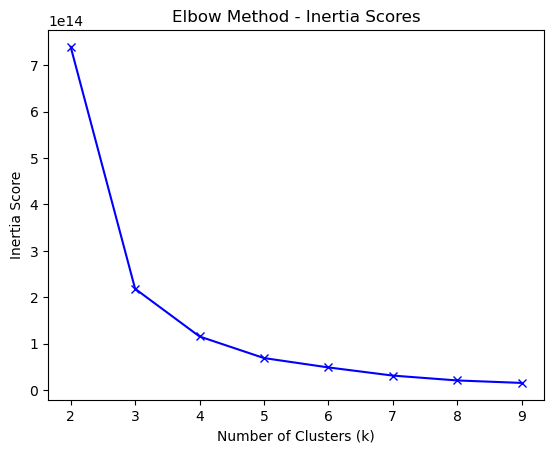

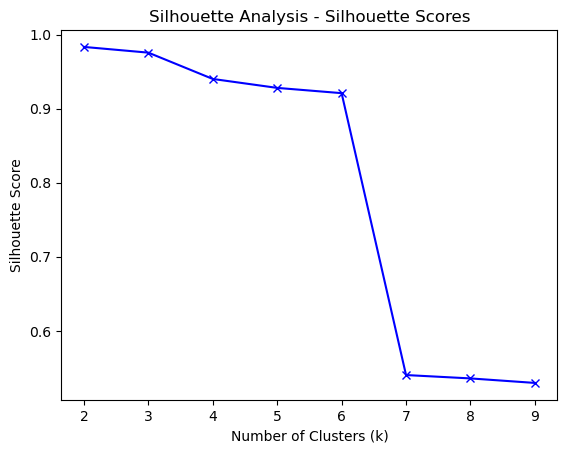

In [30]:
# Select the features for clustering
features = ['work_year', 'experience_level', 'employment_type', 'job_title',
       'salary', 'salary_currency', 'salary_in_usd', 'employee_residence',
       'remote_ratio', 'company_location', 'company_size'] 

# Create a subset dataframe with the selected features
data = df[features]

# Define the range of k values to evaluate
k_values = range(2, 10)  # Adjust the range as needed

# Initialize lists to store the inertia and silhouette scores
inertia_scores = []
silhouette_scores = []

# Iterate over different k values
for k in k_values:
    # Create a KMeans object and fit the data
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data)
    
    # Calculate the inertia and silhouette score for the current k
    inertia_scores.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(data, kmeans.labels_))

# Plot the inertia scores
plt.plot(k_values, inertia_scores, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia Score')
plt.title('Elbow Method - Inertia Scores')
plt.show()

# Plot the silhouette scores
plt.plot(k_values, silhouette_scores, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis - Silhouette Scores')
plt.show()


In simple terms, when using a technique called k-means to analyze data, we often plot a line graph with the number of clusters (k) on one axis and a score on the other axis. The score represents how well the data is grouped into clusters. The graph usually shows a downward trend. We look for a point on the graph where the score levels off or decreases less significantly. This point is called the "elbow point" and suggests an optimal value for k that balances the model's complexity and how well it fits the data.

In our case, we initially thought k=3 would be a good choice. However, when we actually applied k-means to the real data, k=2 seemed to work better. But using k-means to separate the data caused some issues because it created large, unbalanced clusters.

In [31]:
# Determine the number of clusters (k)
k = 2  # Replace with the desired number of clusters

# Create a KMeans object and fit the data
kmeans = KMeans(n_clusters=k)
kmeans.fit(data)

# Retrieve the cluster labels and assign them back to the dataframe
df['cluster'] = kmeans.labels_

# Print the cluster assignments
df.head()

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,cluster
0,0,3,2,84,80000,7,85847,66,2,62,0,0
1,0,2,0,66,30000,19,30000,75,2,70,2,0
2,0,2,0,66,25500,19,25500,75,2,70,2,0
3,0,3,2,47,175000,19,175000,11,2,12,1,0
4,0,3,2,47,120000,19,120000,11,2,12,1,0


In [32]:
# Count the number of data points in each cluster
cluster_counts = df['cluster'].value_counts()

# Print the count of each cluster
print(cluster_counts)

0    3746
1       9
Name: cluster, dtype: int64


The data consists of two clusters: one with 3,746 data points and another with only 9 data points.

This demonstrates that the clusters created by the k-means algorithm are unbalanced, with one cluster being significantly larger than the other. This imbalance can pose challenges in accurately representing and analyzing the data.

In [33]:
# Assuming you have already performed k-means clustering and assigned cluster labels to the dataframe

# Group the dataframe by the 'cluster' column and calculate the mean of each feature
cluster_means = df.groupby('cluster').mean()

# Print the mean values for each feature within each cluster
cluster_means

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
cluster,,,,,,,,,,,
0,0.623599,2.470635,1.99653,39.635611,1.657933e+05,17.425788,137757.518153,68.907368,0.924720,64.709824,0.919381
1,1.777778,1.888889,2.00000,50.555556,1.055556e+07,10.666667,59683.444444,31.111111,1.222222,34.777778,0.555556


However, we still want to know the characteristic of each cluster.

In [34]:
# Determine the unique clusters in the dataframe
clusters = df['cluster'].unique()

# Create subplots with one row and the number of columns equal to the number of features
fig = make_subplots(rows=len(clusters), cols=len(df.columns), subplot_titles="")

# Iterate over each cluster
for cluster_idx, cluster in enumerate(clusters):
    # Filter the dataframe for the current cluster
    cluster_df = df[df['cluster'] == cluster]
    
    # Create box plots for each feature
    for i, feature in enumerate(cluster_df.columns):
        fig.add_trace(go.Box(y=cluster_df[feature], name=f'Cluster {cluster} - {feature}'), row=cluster_idx+1, col=i+1)

        # Set the subplot title text angle to vertical
        fig.update_xaxes(tickangle=-90, row=cluster_idx+1, col=i+1)

# Update layout
fig.update_layout(height=400*len(clusters), width=1000, title='Box Plots of Features for Clusters')

# Show the plot
fig.show()


In the end we still see clear characteristics of each clustuer but it not a good analysis because massive unbalanced problem.

# 7. Pytorch to predict salary

In [35]:
df.columns

Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'salary', 'salary_currency', 'salary_in_usd', 'employee_residence',
       'remote_ratio', 'company_location', 'company_size', 'cluster'],
      dtype='object')

## select features and target
remove unimportant data cluster,salary_currency, salary, cluster

In [36]:
df = df[['work_year', 'experience_level', 'employment_type', 'job_title',
         'salary_in_usd', 'remote_ratio', 'company_location', 'company_size']]
df.head()

,work_year,experience_level,employment_type,job_title,salary_in_usd,remote_ratio,company_location,company_size
0,0,3,2,84,85847,2,62,0
1,0,2,0,66,30000,2,70,2
2,0,2,0,66,25500,2,70,2
3,0,3,2,47,175000,2,12,1
4,0,3,2,47,120000,2,12,1


Identify feature and target for prediction.

In [37]:
features = ['work_year', 'experience_level', 'employment_type', 
            'job_title', 'remote_ratio', 'company_location', 'company_size']

target = ['salary_in_usd']

## split train and test
split train and test data and add to DataLoader

In [38]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)


In [39]:
print("First sample from the training set:")
print(X_train.iloc[0])

print("\nFirst sample from the testing set:")
print(y_train.iloc[0])

First sample from the training set:
work_year            1
experience_level     3
employment_type      2
job_title           33
remote_ratio         0
company_location    62
company_size         1
Name: 2238, dtype: int64

First sample from the testing set:
salary_in_usd    36773
Name: 2238, dtype: int64


In [40]:
# Convert the data into tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [41]:
# Print information
print("Train-Test Split:")
print("Number of samples in training set: ", len(X_train))
print("Number of samples in testing set: ", len(X_test))

print("\nDataLoader Information:")
print("Number of batches in training loader: ", len(train_loader))
print("Number of batches in testing loader: ", len(test_loader))
print("Batch size: ", batch_size)

Train-Test Split:
Number of samples in training set:  3004
Number of samples in testing set:  751

DataLoader Information:
Number of batches in training loader:  94
Number of batches in testing loader:  24
Batch size:  32


## Create Model
Create a new simple model

In [42]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(7, 64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 128)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128, 1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

model = Model()

Check the model

In [43]:
model

Model(
  (fc1): Linear(in_features=7, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)

## Train model
train model

In [44]:
import torch.optim as optim
import time

# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10000
print_interval = 100

train_loss = []  # List to store the training loss values
total_time = 0  # Variable to store the total time elapsed

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    
    start_time = time.time()  # Record the start time for the epoch
    
    for inputs, targets in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    # Calculate average loss for the epoch
    epoch_loss = running_loss / len(train_dataset)
    
    # Append the epoch loss to the train_loss list
    train_loss.append(epoch_loss)
    
    end_time = time.time()  # Record the end time for the epoch
    epoch_time = end_time - start_time  # Calculate the time taken for the epoch
    
    total_time += epoch_time  # Add the epoch time to the total time elapsed
    
    # Print the average loss and total time elapsed for every print_interval epochs
    if (epoch + 1) % print_interval == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Total Time: {total_time:.2f} seconds")
        total_time = 0  # Reset the total time counter

Epoch [100/10000], Loss: 3245630394.8016, Total Time: 15.13 seconds
Epoch [200/10000], Loss: 3161464052.7510, Total Time: 15.53 seconds
Epoch [300/10000], Loss: 3153872489.3316, Total Time: 15.00 seconds
Epoch [400/10000], Loss: 3131674817.2783, Total Time: 15.68 seconds
Epoch [500/10000], Loss: 3086308940.3569, Total Time: 15.44 seconds
Epoch [600/10000], Loss: 3070833249.1505, Total Time: 16.17 seconds
Epoch [700/10000], Loss: 3055925555.1318, Total Time: 15.36 seconds
Epoch [800/10000], Loss: 3044713512.5646, Total Time: 15.44 seconds
Epoch [900/10000], Loss: 3035480490.7803, Total Time: 15.22 seconds
Epoch [1000/10000], Loss: 3012957760.9374, Total Time: 15.32 seconds
Epoch [1100/10000], Loss: 2991255178.0559, Total Time: 15.23 seconds
Epoch [1200/10000], Loss: 2956390454.0293, Total Time: 16.02 seconds
Epoch [1300/10000], Loss: 2924032283.6112, Total Time: 16.28 seconds
Epoch [1400/10000], Loss: 2888389574.2210, Total Time: 16.08 seconds
Epoch [1500/10000], Loss: 2854244518.6897, 

it spend time about 29 minutes for 10,000 epochs

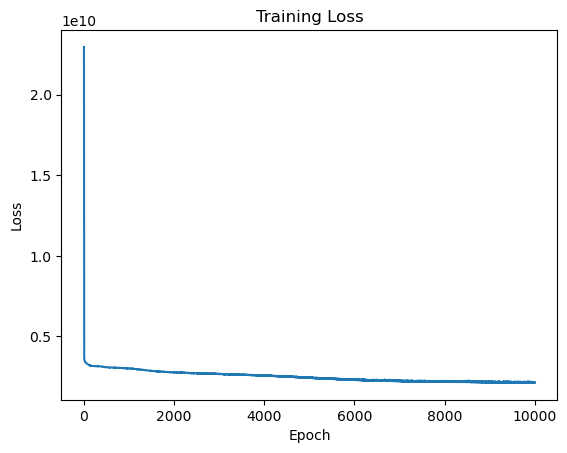

In [45]:
# Plot the training loss
plt.plot(range(1, num_epochs+1), train_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

## Save model

In [46]:
torch.save(model.state_dict(), 'model.pth')

In [47]:
# print model weight
model_dict = model.state_dict()
print(model_dict)

OrderedDict([('fc1.weight', tensor([[-6.5671e+00,  5.4880e+00, -2.2315e+00, -5.0935e-01, -3.9013e+00,
          7.6983e-01, -8.0718e+00],
        [-9.1756e+00,  9.7511e+00, -3.0173e+00, -2.4611e-01,  3.9473e+00,
          5.7781e-01, -5.6300e+00],
        [ 3.9299e-01,  5.3517e+00, -3.7356e+00,  2.6654e-01,  4.4008e-01,
          4.5500e-01,  1.2756e+00],
        [ 9.1881e+00,  3.4659e+00,  1.6379e+00, -4.9043e-01,  2.4722e+00,
          1.5629e+00,  4.0212e+00],
        [-7.0487e+00,  2.0328e+00, -3.0277e+00,  2.2564e-01, -1.0818e+01,
          7.6215e-01, -2.0296e+00],
        [-1.2841e+00,  4.2334e+00, -2.6707e+00, -1.7478e-01,  3.6248e+00,
          7.2827e-01, -6.2919e+00],
        [ 1.5519e-01,  2.0703e-01, -1.9603e-01, -3.6767e-01, -2.9535e-02,
         -1.2653e-01, -1.3899e-01],
        [-2.1054e-01, -3.5854e-01,  1.5267e-01, -3.6007e-01,  4.1762e-02,
         -1.8538e-01, -3.2556e-02],
        [-6.5895e+00,  5.7314e+00, -3.6537e+00,  1.7131e-01, -4.0853e+00,
          1.3195e+

## Eval model

look at prediction of our model

In [48]:
model.eval()  # Set the model to evaluation mode
test_loss = 0.0

predictions = []
actuals = []

with torch.no_grad():
    for inputs, targets in test_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        test_loss += loss.item() * inputs.size(0)

        # Convert the predictions and targets to numpy arrays
        predictions.extend(outputs.numpy())
        actuals.extend(targets.numpy())

# Calculate average test loss
avg_test_loss = test_loss / len(test_dataset)

print(f"\nAverage Test Loss: {avg_test_loss:.4f}")

# Print 5 examples of predictions and actual targets
print("Example Predictions vs Actual Targets:")
for i in range(3):
    print("Example", i+1)
    print("Prediction:", predictions[i])
    print("Actual:", actuals[i])
    print()



Average Test Loss: 2891953128.1385
Example Predictions vs Actual Targets:
Example 1
Prediction: [197809.97]
Actual: [168000.]

Example 2
Prediction: [128067.43]
Actual: [179975.]

Example 3
Prediction: [162396.92]
Actual: [144000.]



The outcome is not bad.

# Thank you for attention 

Thank you for taking the time to read and engage with this information! If you found it helpful or enjoyable, please consider giving it an upvote. Positive feedback like this greatly motivates me to continue exploring new areas and sharing my knowledge.

This notebook provided me with many ideas for exploring data. I got inspiration from the techniques and insights shared in this Kaggle notebook:
https://www.kaggle.com/code/arnabchaki/eda-on-data-science-salaries/notebook